In [156]:
import numpy as np

def compute_eigenbasis(i, mat):
    """
    i-th eigenbasis
    """
    U, S, Vt = np.linalg.svd(mat, full_matrices=False)
    u_i = U[:, i].reshape(-1, 1)
    v_i = Vt[i, :].reshape(1, -1)
    eigenbasis = np.dot(u_i, v_i)
    return eigenbasis

In [157]:

# d = 20
# rows, cols = d//2, d

# # Generate a random matrix
# random_matrix = np.random.rand(rows, cols)
# row_norms = np.linalg.norm(random_matrix, axis=1, keepdims=True)  # Compute row-wise norms
# random_matrix = random_matrix / row_norms


# # top eigenspace, for example
# _ = compute_eigenbasis(0, random_matrix)

# U, S, Vt = np.linalg.svd(random_matrix, full_matrices=False)
# kappa = S[0]/S[-1]
# print(kappa)

In [158]:
# Generate a poorly conditioned random matrix, enforce "halfing" eigenvalue sequence

d = 1000
col = d

kappa = 1/d**2 # want this to be "poly d"
s = [1]
while s[-1] > 2 * kappa:
  s += [s[-1]/2]

row = len(s)

# generate a random basis, U of dimension row x row

U_rand = np.random.randn(row, row)  # d x d matrix with normal distribution

# Perform QR decomposition to obtain an orthonormal basis
U, _ = np.linalg.qr(U_rand)

V_rand = np.random.randn(col, row)
V, _ = np.linalg.qr(V_rand)

random_matrix = np.dot(np.dot(U, np.diag(s)), V.T)
row_norms = np.linalg.norm(random_matrix, axis=1, keepdims=True)  # Compute row-wise norms
random_matrix = random_matrix / row_norms

U, S, Vt = np.linalg.svd(random_matrix, full_matrices=False)
print(S[0]/S[-1]) # see the damage caused by normalizing

430142.3334043848


In [159]:
# Kaczmarz
def kaczmarz(iter, mat, b=0, random=True, n=10):
  """ 
    Kaczmarz Algorithm (equal norm rows): 
      1. sample row from `mat' at random
      2. remove the projection of iterate x along this row

    [iter: number of iterations], [mat: matrix],
    [random: random initialization of x_0 on the sphere], [n: add iterates to tracking list every `n` iterations]
  """
  # start with initial guess
  row, col = mat.shape[0], mat.shape[1]
  x = np.random.rand(col)
  x = x/np.linalg.norm(x)


  iterates = []
  # pick a random row of the matrix
  for i in range(iter):
    a_i = mat[np.random.randint(0, row), :]
    x = x + (b - np.inner(a_i, x))/(np.linalg.norm(a_i)**2) * a_i
    if i % n == 0:
      iterates += [x]
  return iterates

In [160]:
def conjugate_gradient(iter, mat, b=None, random=True, n=10):
    row, col = mat.shape

    # Ensure b is a (row,1) column vector
    if b is None:
        b = np.zeros((row, 1))
    
    # Ensure x is a (col,1) column vector
    x = np.random.rand(col, 1)
    x = x / np.linalg.norm(x)

    iterates = [x]
    r = b - np.matmul(mat, x)
    p = r
    print("Initial p shape:", p.shape)  # Should be (row,1)

    for i in range(iter):
        alpha = np.linalg.norm(r) ** 2 / np.matmul(p.T, np.matmul(mat, p))
        x = x + alpha * p  # x should stay (col,1)

        new_r = r - alpha * np.matmul(mat, p)  # residual
        beta = (np.linalg.norm(new_r) ** 2) / (np.linalg.norm(r) ** 2)
        p = new_r + beta * p
        r = new_r

        if i % n == 0:
            iterates.append(x)

    return iterates


In [161]:
import matplotlib.pyplot as plt

def plot_projections(proj_iterates, top_k=3, n=10):
    nums = [i * n for i in range(len(proj_iterates[0]))]

    # Define a color map for distinct colors
    colors = plt.cm.viridis(np.linspace(0, 1, top_k))

    plt.figure(figsize=(8, 6))  # Set figure size

    for k in range(min(len(proj_iterates), top_k)):
        plt.plot(nums, [proj_iterates[k][i] for i in range(len(proj_iterates[0]))],
                 color=colors[k], label=f"Eigenvector {k+1}", linewidth=2)

    plt.xlabel("Iterations")
    plt.ylabel("Projection")
    plt.legend(title="Eigenspace")  # Add legend title
    plt.show()

    return 0


In [162]:
steps = 500
iterates = kaczmarz(steps, random_matrix, n=1)
print(len(iterates))

# best rank k approx; top k eigenbases
rank_k = [compute_eigenbasis(k, random_matrix) for k in range(S.shape[0])]
# print(rank_k[0].shape)

# project the iterates onto each of the eigenspaces
normalized_iterates = [iterates[i]/np.linalg.norm(iterates[i]) for i in range(len(iterates))]
proj_iterates = [[np.linalg.norm(np.matmul(rank_k[k], normalized_iterates[i])) for i in range(len(normalized_iterates))] for k in range(len(rank_k))]
print(len(proj_iterates), len(proj_iterates[0]))

500
20 500


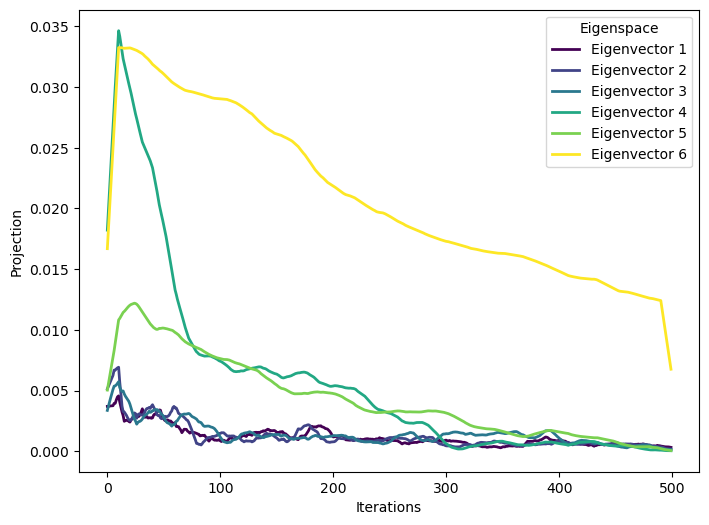

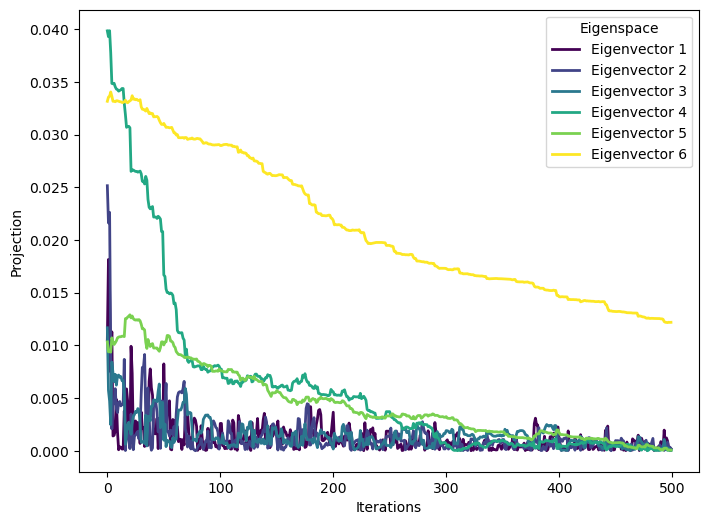

0

In [163]:
# to smooth iterates
def moving_average(data, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'same')

smoothed = [
    moving_average(proj_iterates[k], 20) for k in range(len(rank_k))
]
# plot progress (put a very large number for top_k to see all eigenvalues)
plot_projections(smoothed, top_k=6, n=1)
plot_projections(proj_iterates, top_k=6, n=1)

In [164]:
# Generate a square, PSD matrix for conjugate gradient
d = 200
rows, cols = d, d

# Generate a random matrix
random_matrix = np.random.rand(rows, cols)
random_matrix = np.matmul(random_matrix, random_matrix.T)


# top eigenspace, for example
_ = compute_eigenbasis(0, random_matrix)

U, S, Vt = np.linalg.svd(random_matrix, full_matrices=False)
kappa = S[0]/S[-1]
print(kappa)

120604734.90021352


In [165]:
steps = 100
iterates2 = conjugate_gradient(steps, random_matrix, n=1)
print(len(iterates2))

print(iterates2[0].shape)
# best rank k approx; top k eigenbases
rank_k = [compute_eigenbasis(k, random_matrix) for k in range(S.shape[0])]
# print(rank_k[0].shape)

# project the iterates onto each of the eigenspaces
normalized_iterates2 = [iterates2[i]/np.linalg.norm(iterates[i]) for i in range(len(iterates2))]
proj_iterates2 = [[np.linalg.norm(np.matmul(rank_k[k], normalized_iterates2[i])) for i in range(len(normalized_iterates2))] for k in range(len(rank_k))]

Initial p shape: (200, 1)
101
(200, 1)


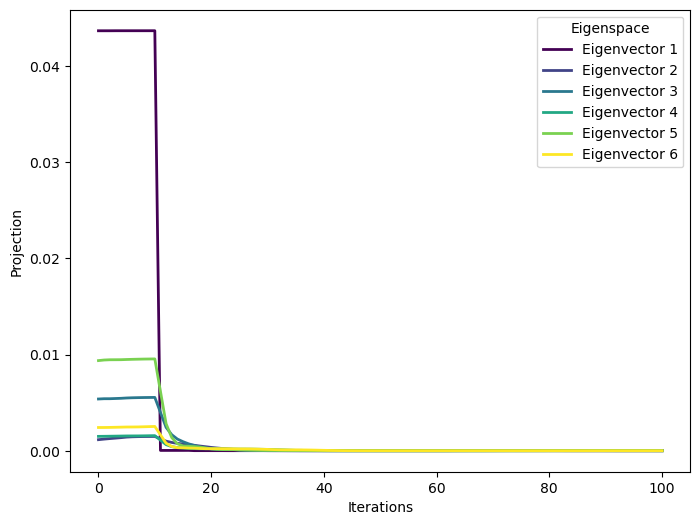

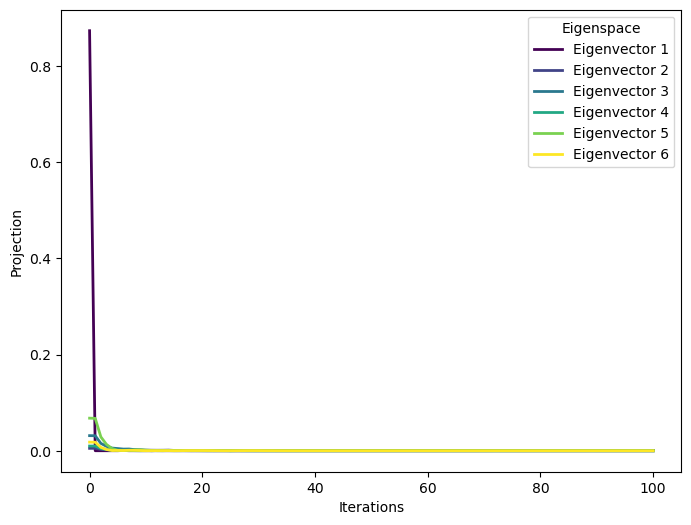

0

In [177]:
# to smooth iterates
def moving_average(data, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'same')

smoothed2 = [
    moving_average(proj_iterates2[k], 20) for k in range(len(rank_k))
]
# plot progress (put a very large number for top_k to see all eigenvalues)
plot_projections(smoothed2, top_k=6, n=1)
plot_projections(proj_iterates2, top_k=6, n=1)

Think about a matrix $A \in \mathbb{R}^{4 \times 4}$ with eigenvalues $(1, 1, 1/\kappa, 1/\kappa)$. So, $$ A = v_1 v_1 ^\top + v_2 v_2 ^\top  + \frac{1}{\kappa} (v_3 v_3 ^\top + v_4 v_4^\top)$$
where $v_i$ are mutually orthogonal unit eigenvectors. Think about $A$ as a mixture of projections orthogonal to $T = \text{span}(v_1, v_2)$ and $B = \text{span}(v_3, v_4)$, its top and bottom subspaces.



In [230]:
kappa = 5
depth = 4

eig = np.array([[1/(kappa ** i), 1/(kappa ** i)] for i in range(depth//2)]).ravel()
S = np.diag(eig)

V_rand = np.random.randn(depth, depth)  # d x d matrix with normal distribution

# Perform QR decomposition to obtain an orthonormal basis
V, _ = np.linalg.qr(V_rand)

A = np.dot(V, np.dot(S, V.T))
row_norms = np.linalg.norm(A, axis=1, keepdims=True)  # Compute row-wise norms
A = A / row_norms


U, S, Vt = np.linalg.svd(A, full_matrices=False)
print(S)
print(U)
print(Vt.T)

[1.60654003 1.07224429 0.43822286 0.27799646]
[[-0.57650319 -0.12152696 -0.80715199 -0.03716102]
 [ 0.59455271  0.10705066 -0.47038876  0.64325861]
 [ 0.07128603  0.91941307 -0.17342816 -0.34571748]
 [-0.55594015  0.35840055  0.31170941  0.68214137]]
[[-0.4591336  -0.09064047 -0.88176924 -0.0588528 ]
 [ 0.62819487  0.08917571 -0.38114511  0.67241899]
 [ 0.09996137  0.94240913 -0.12945113 -0.29174501]
 [-0.62014133  0.30934935  0.24587358  0.67769749]]


In [179]:
# # Sadly, normalizing rows destroys the nice structure :(
# V_1, V_2 = V[:, :2], V[:, 2:]   # principal and minor eigenspace
# print(V_1.shape, V_2.shape)
# x = np.random.rand(4)
# x = x/np.linalg.norm(x)
# print("This norm is significant: ", np.linalg.norm(np.dot(A, x) - (np.dot(np.dot(V_1, V_1.T), x) + 1/kappa * np.dot(np.dot(V_2, V_2.T), x))))

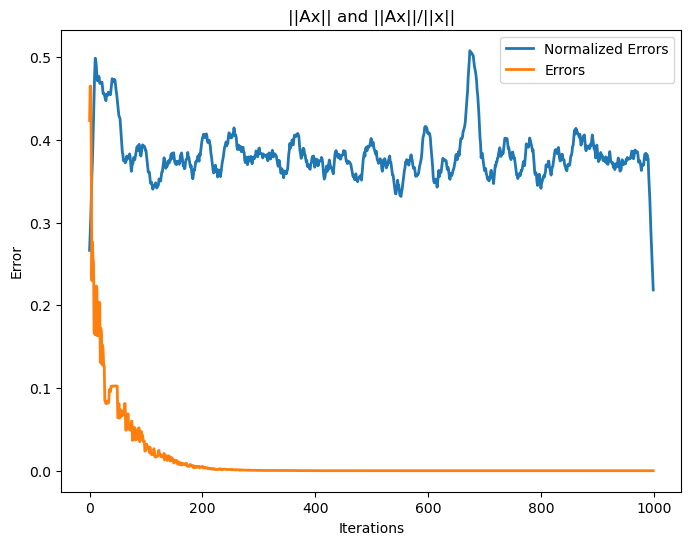

[0.758939746435212, 0.6854020446130676, 0.6854020446130676, 0.5987904418933929, 0.539561055133827, 0.5368861239922768, 0.4678360256299262, 0.4654561920411563, 0.4441429642714127, 0.4441429642714127, 0.4427990961703959, 0.4427990961703959, 0.4313230992383514, 0.43082619602473543, 0.4252045017929232, 0.42167142448669104, 0.3723486587079561, 0.3723486587079561, 0.3723486587079561, 0.3527533211801371, 0.3441736197194597, 0.3048190086049549, 0.2961535245946826, 0.28515441144569725, 0.27752855416062827, 0.24038611927108527, 0.24038611927108527, 0.217962522255296, 0.217962522255296, 0.21792282296068757, 0.21790184629506615, 0.21789076318591646, 0.21789076318591646, 0.21789076318591646, 0.2178849075819315, 0.20157185858590157, 0.19995783902350447, 0.19995783902350447, 0.199878654415566, 0.199878654415566, 0.19987478515723386, 0.1998745961280452, 0.19987458689328078, 0.19987458689328078, 0.19987458689328078, 0.1998745864421291, 0.1998745864421291, 0.19987458642008873, 0.19987458641901196, 0.199

In [231]:
steps = 1000
b = 0 # np.random.randn(1)

iterates = kaczmarz(steps, A, b=b, n=1)

errors = [np.linalg.norm(np.dot(A, iterates[i])) for i in range(len(iterates))]

normalized_iterates = [iterat/np.linalg.norm(iterat) for iterat in iterates]
normalized_errors = [np.linalg.norm(np.matmul(A, normalized_iterates[i])) for i in range(len(normalized_iterates))]

norms = [np.linalg.norm(iterates[i]) for i in range(len(iterates))]
nums = [i for i in range(len(iterates))]

smoothed_normalized_errors = moving_average(normalized_errors, 20)
smoothened_errors = moving_average(errors, 20)

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, smoothed_normalized_errors, label=f"Normalized Errors", linewidth=2)
plt.plot(nums, errors, label=f"Errors", linewidth=2)
plt.title("||Ax|| and ||Ax||/||x||")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

print(norms)

In [232]:
# full rank case
print(kappa)
print(normalized_errors[-10])
print("balanced between T, B: ", 1/kappa * 1 + (1 - 1/kappa) * 1/kappa)



5
0.4082856333924861
balanced between T, B:  0.36


[0.40561728 0.59030574 0.19886071 0.1531591 ]


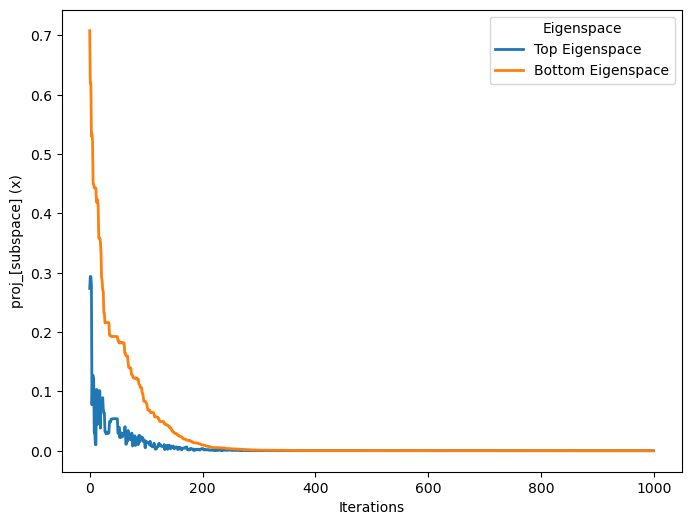

In [233]:
U, S, Vt = np.linalg.svd(A, full_matrices=False)

print(iterates[0])

# Projection onto major component
proj_1 = [np.linalg.norm(np.dot(np.dot(U[:, :2], Vt[:2, :]), x)) for x in iterates]

# Projection onto minor component
proj_2 = [np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in iterates]

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, proj_1, linewidth=2, label=f"Top Eigenspace")
plt.plot(nums, proj_2, linewidth=2, label=f"Bottom Eigenspace")

plt.xlabel("Iterations")
plt.ylabel("proj_[subspace] (x)")
plt.legend(title="Eigenspace")  # Add legend title

plt.show()

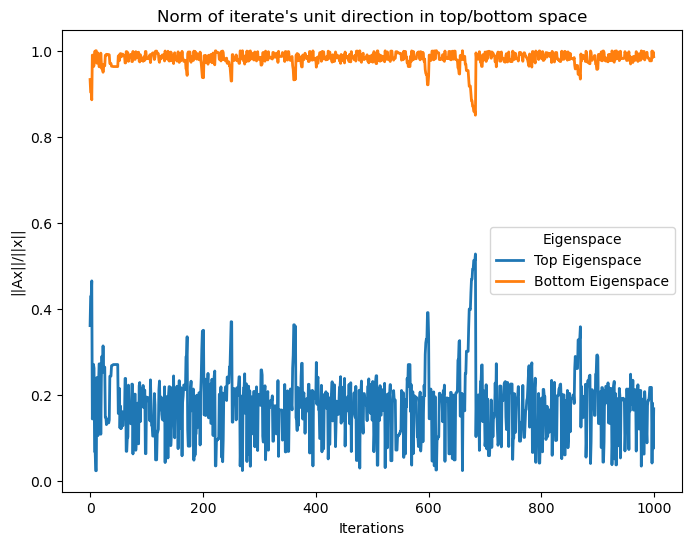

In [234]:
# Normalized projection onto major component
proj_1 = [np.linalg.norm(np.dot(np.dot(U[:, :2], Vt[:2, :]), x)) for x in normalized_iterates]

# Normalized projection onto minor component
proj_2 = [np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in normalized_iterates]

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, proj_1, linewidth=2, label=f"Top Eigenspace")
plt.plot(nums, proj_2, linewidth=2, label=f"Bottom Eigenspace")
plt.title("Norm of iterate's unit direction in top/bottom space")
plt.xlabel("Iterations")
plt.ylabel("||Ax||/||x||")
plt.legend(title="Eigenspace")  # Add legend title

plt.show()

In [235]:
# Do iterates in the smaller subspace "spin"?
norm_proj_2 = [(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) / np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in normalized_iterates]     # pretty much just x again, but just to be careful!
# print(norm_proj_2)
consecutive_angles = [0 for i in range(len(norm_proj_2 ) - 1)]
for i in range(1, len(norm_proj_2)):
    consecutive_angles[i-1] = np.dot(norm_proj_2[i].T, norm_proj_2[i-1])

print(consecutive_angles)

[0.9999316959924474, 1.0, 0.9908734073918002, 0.9982370699013707, 0.9996290611078982, 0.9997903277216843, 0.9999205003926753, 0.9974368644252494, 1.0, 0.999954896812411, 1.0, 0.9981579507192557, 0.9999821701144255, 0.9992974678697658, 0.9993162324146726, 0.9995667832524213, 0.9999999999999999, 0.9999999999999999, 0.9971461839182083, 0.9979606894789734, 0.9994946104330228, 0.9984566054713533, 0.996463140480679, 0.9995970088620285, 0.9992076960704551, 1.0, 0.9897733754643716, 1.0, 0.9999923725657066, 0.9999895055874437, 0.9999978889173141, 1.0, 1.0, 0.9999970560577427, 0.9987790604617364, 0.9999045391252425, 1.0000000000000002, 0.9999932804703384, 1.0, 0.9999997659784595, 0.9999999837534943, 0.999999999440731, 1.0000000000000002, 1.0000000000000002, 0.9999999999612004, 1.0000000000000002, 0.9999999999986652, 0.9999999999999074, 1.0, 0.992561649840694, 1.0, 0.9996347800714898, 0.9993125159775125, 0.999887258786601, 0.9998120842621616, 0.9999989047042801, 0.9999610667659317, 0.999927944346

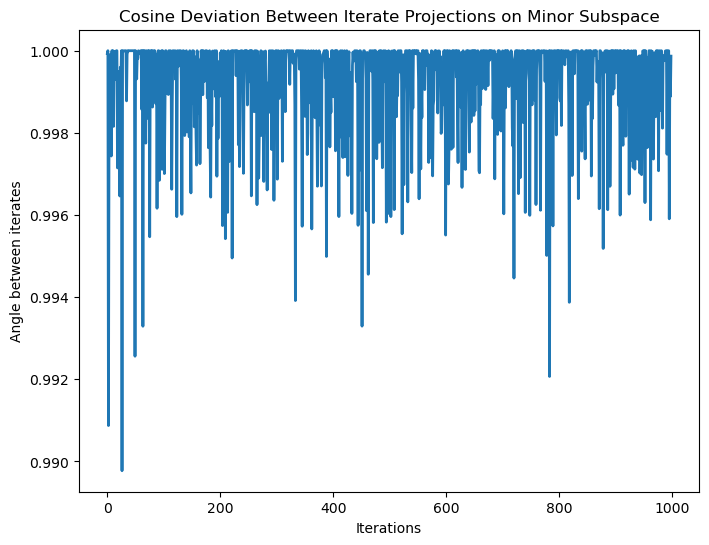

In [236]:
import matplotlib.pyplot as plt

nums = [i for i in range(len(consecutive_angles))]
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, consecutive_angles, linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Angle between iterates")
# plt.ylim(0, 1)  # Enforce y-axis range
plt.title("Cosine Deviation Between Iterate Projections on Minor Subspace")
plt.show()

Conjugate Gradient

In [237]:
# Symmetrizing A; equivalently, think of solving A^T A x = A^T b = 0
B = np.matmul(A.T, A)
U, S, Vt = np.linalg.svd(B)
print(S)

[2.58097088 1.14970781 0.19203928 0.07728203]


Initial p shape: (4, 1)


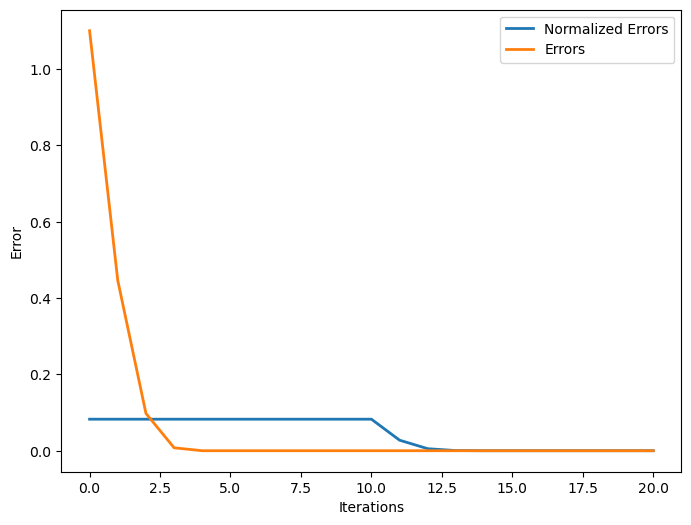

[0.758939746435212, 0.6854020446130676, 0.6854020446130676, 0.5987904418933929, 0.539561055133827, 0.5368861239922768, 0.4678360256299262, 0.4654561920411563, 0.4441429642714127, 0.4441429642714127, 0.4427990961703959, 0.4427990961703959, 0.4313230992383514, 0.43082619602473543, 0.4252045017929232, 0.42167142448669104, 0.3723486587079561, 0.3723486587079561, 0.3723486587079561, 0.3527533211801371, 0.3441736197194597, 0.3048190086049549, 0.2961535245946826, 0.28515441144569725, 0.27752855416062827, 0.24038611927108527, 0.24038611927108527, 0.217962522255296, 0.217962522255296, 0.21792282296068757, 0.21790184629506615, 0.21789076318591646, 0.21789076318591646, 0.21789076318591646, 0.2178849075819315, 0.20157185858590157, 0.19995783902350447, 0.19995783902350447, 0.199878654415566, 0.199878654415566, 0.19987478515723386, 0.1998745961280452, 0.19987458689328078, 0.19987458689328078, 0.19987458689328078, 0.1998745864421291, 0.1998745864421291, 0.19987458642008873, 0.19987458641901196, 0.199

In [238]:
steps = 20
b = 0 # np.random.randn(1)

cg_iterates = conjugate_gradient(steps, B, b=b, n=1)

cg_errors = [np.linalg.norm(np.dot(B, cg_iterates[i])) for i in range(len(cg_iterates))]

cg_normalized_iterates = [iterat/np.linalg.norm(iterat) for iterat in cg_iterates]
cg_normalized_errors = [np.linalg.norm(np.matmul(B, cg_normalized_iterates[i])) for i in range(len(cg_normalized_iterates))]

# norms = [np.linalg.norm(iterates[i]) for i in range(len(iterates))]
nums = [i for i in range(len(cg_iterates))]

cg_smoothed_normalized_errors = moving_average(cg_normalized_errors, 20)
cg_smoothened_errors = moving_average(cg_errors, 20)

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, cg_smoothened_errors, label=f"Normalized Errors", linewidth=2)
plt.plot(nums, cg_errors, label=f"Errors", linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

print(norms)

[0.40561728 0.59030574 0.19886071 0.1531591 ]


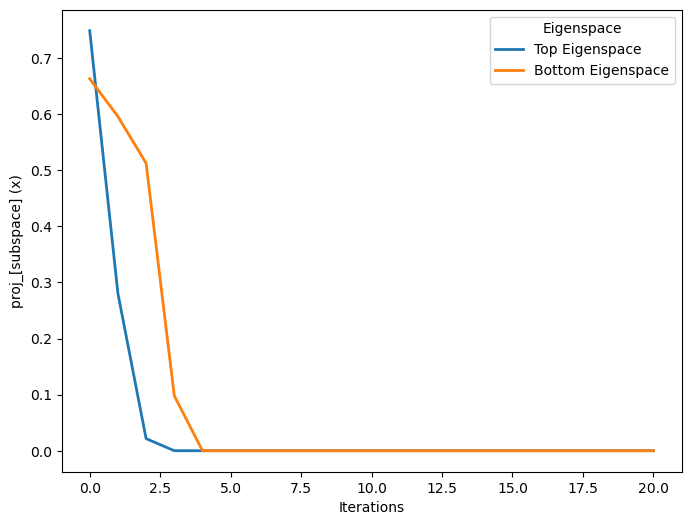

In [239]:
U, S, Vt = np.linalg.svd(B, full_matrices=False)

print(iterates[0])

# Projection onto major component
proj_1 = [np.linalg.norm(np.dot(np.dot(U[:, :2], Vt[:2, :]), x)) for x in cg_iterates]

# Projection onto minor component
proj_2 = [np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in cg_iterates]

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, proj_1, linewidth=2, label=f"Top Eigenspace")
plt.plot(nums, proj_2, linewidth=2, label=f"Bottom Eigenspace")

plt.xlabel("Iterations")
plt.ylabel("proj_[subspace] (x)")
plt.legend(title="Eigenspace")  # Add legend title

plt.show()

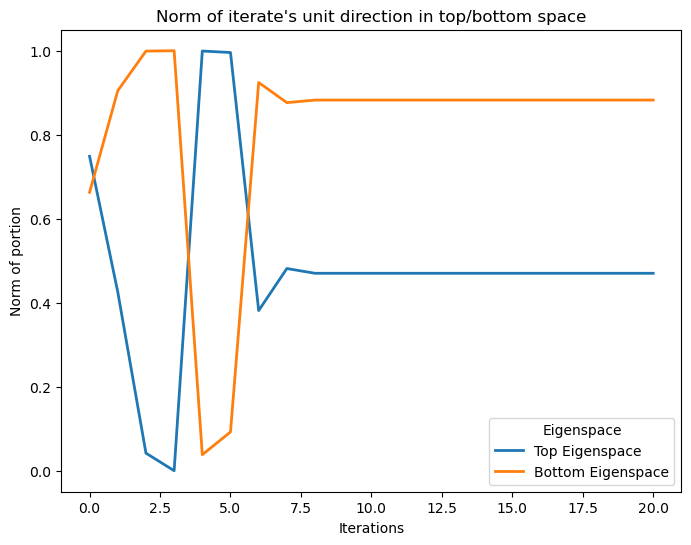

In [240]:
# Normalized projection onto major component
cg_proj_1 = [np.linalg.norm(np.dot(np.dot(U[:, :2], Vt[:2, :]), x)) for x in cg_normalized_iterates]

# Normalized projection onto minor component
cg_proj_2 = [np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in cg_normalized_iterates]

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, cg_proj_1, linewidth=2, label=f"Top Eigenspace")
plt.plot(nums, cg_proj_2, linewidth=2, label=f"Bottom Eigenspace")
plt.title("Norm of iterate's unit direction in top/bottom space")
plt.xlabel("Iterations")
plt.ylabel("Norm of portion")
plt.legend(title="Eigenspace")  # Add legend title

plt.show()

In [210]:
# Do iterates in the smaller subspace "spin"?
cg_norm_proj_2 = [(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) / np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in cg_normalized_iterates]     # pretty much just x again, but just to be careful!
# print(norm_proj_2)
cg_consecutive_angles = [0 for i in range(len(cg_norm_proj_2 ) - 1)]
for i in range(1, len(cg_norm_proj_2)):
    cg_consecutive_angles[i-1] = np.dot(cg_norm_proj_2[i].T, cg_norm_proj_2[i-1]).item()

print(cg_consecutive_angles)

[0.9976537946284679, 0.7343203846590611, 0.8787861983785014, 0.868602905973124, 0.9986595082767142, 0.9854739915365465, 0.9996788558313882, 0.9999257767202576, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002]


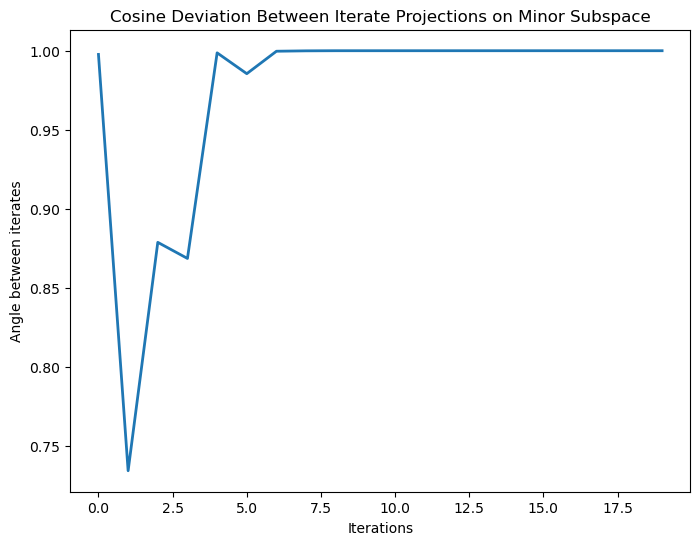

In [241]:
import matplotlib.pyplot as plt

nums = [i for i in range(len(cg_consecutive_angles))]
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, cg_consecutive_angles, linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Angle between iterates")
# plt.ylim(0, 1)  # Enforce y-axis range
plt.title("Cosine Deviation Between Iterate Projections on Minor Subspace")
plt.show()